In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

import os 
os.chdir(r'/content/drive/MyDrive/NTU_Course/AI6128-Urban_Computing/Lecture/Assignment1/')

Mounted at /content/drive/


In [ ]:
# clone from github repo directly
# !git clone https://github.com/location-competition/indoor-location-competition-20
# !mv ./indoor-location-competition-20/* ./

fatal: destination path 'indoor-location-competition-20' already exists and is not an empty directory.
mv: cannot stat './indoor-location-competition-20/*': No such file or directory


In [ ]:
# install necessary packages
!pip install numpy scipy dataclasses plotly pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Check if GPU is available (enable GPU through: Runtime-->Change runtime type --> select "GPU" in hardware accelerator dropdown list)

In [ ]:
import torch
print(torch.cuda.get_device_name(0))

Tesla T4


import package

In [ ]:
import sys
import random
import seaborn as sns
import matplotlib as mpl
import matplotlib.image as im
import matplotlib.pyplot as plt

# import supported functions
from io_f import *
from compute_f import *
from main import *
from visualize_f import *

compute waypoints

In [ ]:
def compute_waypoints(path, is_aug_wap=False, flag=True):
    wap = []
    accel = []
    rotat = []

    # read text file
    with open(path) as f:
        for line in f.readlines():
            line = line.strip()
            if not line or line[0] == '#':
                continue
            l_data = line.split('\t')
            if l_data[1] == 'TYPE_WAYPOINT':
                # timestamps,x,y
                wap.append([int(l_data[0]), float(l_data[2]), float(l_data[3])])
            if is_aug_wap:
                if l_data[1] == 'TYPE_ACCELEROMETER':
                    # timestamps,x,y,z
                    accel.append([int(l_data[0]), float(l_data[2]), float(l_data[3]), float(l_data[4])])
                if l_data[1] == 'TYPE_ROTATION_VECTOR':
                    # timestamps,x,y,z
                    rotat.append([int(l_data[0]), float(l_data[2]), float(l_data[3]), float(l_data[4])])

    wap = np.array(wap)
    if is_aug_wap:
        accel, rotat = np.array(accel), np.array(rotat)
        # using accel, rotat data to augment the wappoints 
        wap = compute_step_positions(accel, rotat, wap) 

    if flag:
        return wap[:,1:]
    return wap


 visualize ground truth positions of each floor

In [ ]:
def vis_waypoints(site, floor, save_dir=None, dpi=200, is_aug_wap=False):
    floor_waps = []
    sum_waps = 0 

    floor_path = f'./data/{site}/{floor}'
    floor_data_path = floor_path + '/path_data_files'
    txt_filenames = list(Path(floor_data_path).resolve().glob("*.txt"))
    for filename in txt_filenames:
        txt_path = os.path.join(floor_data_path, filename)
        txt_wap = compute_waypoints(txt_path, is_aug_wap=is_aug_wap, flag=True)
        floor_waps.append(txt_wap)

    # read floor info to extract height and width of map
    floor_info_filename = floor_path + '/floor_info.json'
    with open(floor_info_filename) as f:
        floor_info = json.load(f)
    width_meter = floor_info["map_info"]["width"]
    height_meter = floor_info["map_info"]["height"]

    # visualize waypoints
    img = im.imread(floor_path + '/floor_image.png')
    random.seed(42) 
    sns.reset_orig()
    colors = sns.color_palette('dark', n_colors=10)
    plt.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
    plt.clf()
    plt.imshow(img)
    scale = (img.shape[0] / height_meter + img.shape[1] / width_meter) / 2
    for i, waps in enumerate(floor_waps):
        x, y = zip(*waps)
        sum_waps += len(x)
        x, y = np.array(x), np.array(y)
        x, y = x * scale, img.shape[0] - y * scale
        plt.plot(x, y, linewidth='0.5', linestyle='solid', marker='o', markersize=3)

    if not is_aug_wap:
        plt.title(f"{site} - {floor} - {sum_waps} Waypoints".title())
    else:
        plt.title(f"{site} - {floor} - {sum_waps} Augmented Waypoints".title())

    plt.xticks((np.arange(30, width_meter, 30) * scale).astype('int'),
                np.arange(30, width_meter, 30).astype('int'))
    plt.yticks((img.shape[0] - np.arange(30, height_meter, 30) * scale).astype('int'),
                np.arange(30, height_meter, 30).astype('int'))
    plt.tight_layout()

    if save_dir:
        if not is_aug_wap:
            save_path = os.path.join(save_dir, site + "--" + floor)
            # plt.show()
        else:
            save_path = os.path.join(save_dir, site + "--" + floor + "--" + "Augmented")
            # plt.show()
        plt.savefig(save_path, dpi=dpi)
    else:
        plt.show()

    return sum_waps

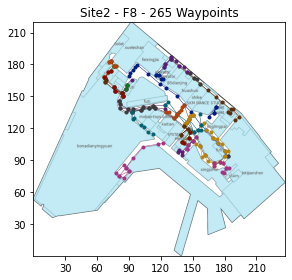

In [ ]:
sites = ['site1','site2']
floor1 = ['B1','F1','F2','F3','F4']
floor2 = ['B1','F1','F2','F3','F4','F5','F6','F7','F8']
save_dir = './output/'
for site in sites:
    if site == 'site1':
        for floor in floor1:
            vis_waypoints(site,floor,save_dir=save_dir, dpi=200,is_aug_wap=False)
    elif site == 'site2':
        for floor in floor2:
            vis_waypoints(site,floor,save_dir=save_dir, dpi=200,is_aug_wap=False)
    else:
        break


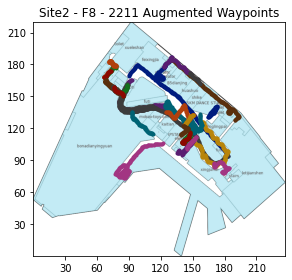

In [ ]:
sites = ['site1','site2']
floor1 = ['B1','F1','F2','F3','F4']
floor2 = ['B1','F1','F2','F3','F4','F5','F6','F7','F8']
save_dir = './output/'
for site in sites:
    if site == 'site1':
        for floor in floor1:
            vis_waypoints(site,floor,save_dir=save_dir, dpi=200,is_aug_wap=True)
    elif site == 'site2':
        for floor in floor2:
            vis_waypoints(site,floor,save_dir=save_dir, dpi=200,is_aug_wap=True)
    else:
        break


1034

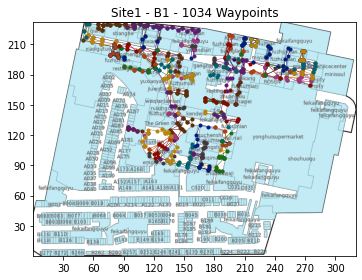

In [ ]:
save_dir = './output/'
vis_waypoints('site1','B1',save_dir=save_dir, dpi=200,is_aug_wap=False)